In [9]:
import numpy as np
class Node:
    """
    我们把这个Node类作为这个神经网络的基础模块
    """
    def __init__(self,inputs=[],name=None,is_trainable=False):
        
        self.inputs = inputs  #这个节点的输入，输入的是Node组成的列表
        self.outputs = []     #这个节点的输出节点
        self.name = name
        self.is_trainable = is_trainable
        for n in self.inputs:
            n.outputs.append(self)  #这个节点正好对应了这个输人的输出节点，从而建立了连接关系
            
        self.value = None  #每个节点必定对应有一个值
        self.gradients = {}  #每个节点对上个节点的梯度，
                             
    def forward(self):
        """
        先预留一个方法接口不实现，在其子类中实现,且要求其子类一定要实现，不实现的时话会报错。
        """
        raise NotImplemented  
        
    def backward(self):
        
        raise NotImplemented
        
    def __repr__(self):
        
        return "Node:{}".format(self.name)  


## Placeholder 

In [10]:
class Placeholder(Node):
    """
    作为x,k,b,weights和bias这类需要赋初始值和更新值的类
    """
    def __init__(self,name=None,is_trainable=True):
        
        Node.__init__(self,name=name,is_trainable=is_trainable)
        
        
    def forward(self,value=None):
        
        if value is not None: self.value = value
        
    def backward(self):
        
        self.gradients[self] = np.zeros_like(self.value).reshape((self.value.shape[0],-1))
        
        for n in self.outputs:
           
            self.gradients[self] += n.gradients[self].reshape((n.gradients[self].shape[0],-1))  #没有输入。
            
class Linear(Node):
    
    def __init__(self,x=None,weight=None,bias=None,name=None,is_trainable=False):
        
        Node.__init__(self,[x,weight,bias],name=name,is_trainable=is_trainable)
        
    
    def forward(self):
        
        x, k, b =self.inputs[0], self.inputs[1], self.inputs[2]
        
        self.value = np.dot(x.value,k.value) + b.value.squeeze()
      
    def backward(self):
        x, k, b =self.inputs[0], self.inputs[1], self.inputs[2]
         
        self.gradients[k] = np.zeros_like(k.value)
        self.gradients[b] = np.zeros_like(b.value).reshape((len(np.zeros_like(b.value))))
        self.gradients[x] = np.zeros_like(x.value)
        
        for n in self.outputs:
            
            gradients_from_loss_to_self = n.gradients[self] 
            self.gradients[k] += np.dot(gradients_from_loss_to_self.T,x.value).T
            self.gradients[b] += np.mean(gradients_from_loss_to_self,axis=0,keepdims=False).reshape((len(np.zeros_like(b.value))))
            self.gradients[x] += np.dot(gradients_from_loss_to_self,k.value.T)

class Sigmoid(Node):
    
    def __init__(self,x,name=None,is_trainable=False):
        
        Node.__init__(self,[x],name=name,is_trainable=is_trainable)
        self.x = self.inputs[0]
    
    def _Sigmoid(self,x):
        
        return 1. /(1+np.exp(-1*x))
    
    def forward(self):
        
        self.value = self._Sigmoid(self.x.value)
        
    def partial(self):
        
        return self._Sigmoid(self.x.value) * (1 - self._Sigmoid(self.x.value))
    
    def backward(self):
        
        self.gradients[self.x] = np.zeros_like(self.value)
     
        for n in self.outputs:
            gradients_from_loss_to_self = n.gradients[self] #输出节点对这个节点的偏导，self：指的是本身这个节点
            self.gradients[self.x] += gradients_from_loss_to_self*self.partial()
            

class ReLu(Node):
    def __init__(self,x,name=None,is_trainable = False):
        Node.__init__(self,[x],name=name,is_trainable=is_trainable)
        self.x = self.inputs[0]
        
    def forward(self):
        self.value = self.x.value*(self.x.value > 0)
    
    def backward(self):
        self.gradients[self.x] = np.zeros_like(self.value)
        
        for n in self.outputs:
            gradients_from_loss_to_self = n.gradients[self]
            self.gradients[self.x] += gradients_from_loss_to_self*(self.x.value > 0)
            
class MSE(Node):
    
    def __init__(self,y_pre,y,name,is_trainable=False):
        
        Node.__init__(self,[y_pre,y],name=name,is_trainable=is_trainable)
        self.y_pre, self.y = self.inputs[0],self.inputs[1]
        
  
    def forward(self):
        y = self.y.value.reshape(-1,1)
        y_pre = self.y_pre.value.reshape(-1,1)
       
        assert(y.shape == y_pre.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - y_pre

        self.value = np.mean(self.diff**2)
        
  
    def backward(self):
        
        
        self.gradients[self.y] = (2 / self.m) * self.diff
        self.gradients[self.y_pre] = (-2 / self.m) * self.diff  
            


In [11]:
import random
"""
使用拓扑排序找到网络节点的前向计算顺序（反向传播反过来就行）
"""
def toplogical(graph):
    
    sorted_graph_nodes = []
    
    while graph: 
        all_nodes_have_inputs = set()
        all_nodes_have_outputs = set()
        
        for have_output_node, have_inputs in graph.items():
            all_nodes_have_outputs.add(have_output_node)#包括只有输出的节点 和既有输入又有输出的点
            all_nodes_have_inputs |= set(have_inputs) #有输入的点：包括既有输入和输出的点 和只有输入的点（末尾终点）
        need_removed_nodes = all_nodes_have_outputs - all_nodes_have_inputs #减去之后留下只有输出的节点
        
        if need_removed_nodes:
            node = random.choice(list(need_removed_nodes))  #随机删去一个节点
            visited_next = [node]
            
            if len(graph) == 1: visited_next += graph[node] #当最后删到只留一个有输出的节点
                #的时候，那么需要把这个节点对应的输出节点也加上，否则会漏掉这个点
                
            graph.pop(node)
            sorted_graph_nodes += visited_next
            
            for _, links in graph.items():
                if node in links: links.remove(node) #如果删除的节点在别的节点的连接关系内，那么把他从连接关系里删除
        else:
            break
            
    return sorted_graph_nodes
    
"""
根据feed_dict和网络节点的初始化结果,建立网络的连接关系
"""

from collections import defaultdict
def convert_feed_dict_graph(feed_dict):
    computing_graph = defaultdict(list)
    
    nodes = [n for n in feed_dict]
    
    while nodes:
        n = nodes.pop(0)  #移除列表中的一个元素（默认最后一个元素），并且返回该元素的值
        
    
        if isinstance(n,Placeholder):
            n.value = feed_dict[n]
        if n in computing_graph:continue
        
        for m in n.outputs:
            computing_graph[n].append(m) #建立好网络连接关系
            nodes.append(m)
            
    return computing_graph
   
"""
根据网络的连接关系，进行拓扑排序。
"""
def toplogical_sort(feed_dict):
    
    graph = convert_feed_dict_graph(feed_dict)
    
    return toplogical(graph)


In [12]:
#正向传播
def forward(graph,monitor=False,train = True):
    for node in graph if train else graph[:-1]:
        if monitor:print('forward:{}'.format(node))
        node.forward()
#反向传播
def backward(graph,monitor=False):
    for node in graph[::-1]:
        if monitor:print('backward:{}'.format(node))
        node.backward() 
"""
进行前向和反向传播计算
"""
"""
进行前向和反向传播计算
"""
def run_steps(graph_topological_sort_order,monitor=False,train=True):
    if train:
        forward(graph_topological_sort_order,monitor)
        backward(graph_topological_sort_order,monitor)
    else:
        forward(graph_topological_sort_order,monitor,train)


In [13]:
def optimize(graph,learning_rate=1e-2):
    for node in graph:
        if node.is_trainable:
            node.value = node.value.reshape((node.value.shape[0],-1))
            node.gradients[node] = node.gradients[node].reshape((node.gradients[node].shape[0],-1))
            node.value += -1 * node.gradients[node] * learning_rate


In [14]:
import os,zipfile
from glob import glob

def compress(zip_file, input_dir):
    f_zip = zipfile.ZipFile(zip_file, 'w')
    for root, dirs, files in os.walk(input_dir):
        for f in files:
             # 获取文件相对路径，在压缩包内建立相同的目录结构
            abs_path = os.path.join(os.path.join(root, f))
            rel_path = os.path.relpath(abs_path, os.path.dirname(input_dir))
            f_zip.write(abs_path, rel_path, zipfile.ZIP_STORED)

def extract(zip_file,pwd=None):
    if pwd:
        pwd = pwd.encode()
    f_zip = zipfile.ZipFile(zip_file, 'r')
    # 解压所有文件到指定目录
    f_zip.extractall(zip_file.split(".")[0],pwd=pwd)

    #return txt_file

import shutil
def save_model(save_path,model):

    save_path = save_path.split('.')[0]
    if not os.path.exists(save_path): #如果文件夹不存在，创建一个新的
        os.mkdir(save_path)

    for name, node in vars(model).items():
        if isinstance(node, Placeholder):
            if node.is_trainable:
                np.savetxt("{}/{}.txt".format(save_path,node.name), node.value)
    compress(os.getcwd() + '/{}.zip'.format(save_path), save_path, )
    shutil.rmtree(save_path)



def load_model(load_path,model):

    extract(load_path)
    load_path = load_path.split(".")[0]
    model_path = np.array(glob(load_path+"/*/*"))
    for name, node in vars(model).items():
        if isinstance(node, Placeholder):
            if node.is_trainable:
                for path in model_path:
                    if path.split(".")[0].split("/")[2] == node.name:
                        node.value = np.loadtxt(path)
    shutil.rmtree(load_path)


In [15]:
from sklearn.datasets import load_boston
from tqdm import tqdm
from sklearn.utils import shuffle, resample
import numpy as np
import matplotlib.pyplot as plt

#加载数据
dataset = load_boston()
"""
print(dataset['feature_names'])
print(dataset['data'].shape)
print(dataset['target'].shape)
"""
x_ = dataset['data']
y_ = dataset['target']

# Normalize data
x_ = (x_ - np.mean(x_, axis=0)) / np.std(x_, axis=0)


# 定义网络
class MLP():

    def __init__(self, x_, y_):

        self.x, self.y = Placeholder(
            name='x', is_trainable=False), Placeholder(name='y',
                                                       is_trainable=False)
        self.w1, self.b1 = Placeholder(name='w1'), Placeholder(name='b1')
        self.w2, self.b2 = Placeholder(name='w2'), Placeholder(name='b2')
        self.w3, self.b3 = Placeholder(name='w3'), Placeholder(name='b3')

        self.output1 = Linear(self.x, self.w1, self.b1, name='linear1')
        self.output2 = Sigmoid(self.output1, name='sigmoid')
        self.output3 = Linear(self.output2, self.w2, self.b2, name='linear2')
        self.output4 = ReLu(self.output3, name='Relu')
        self.y_pre = Linear(self.output4, self.w3, self.b3, name='linear3')
        self.MSE_loss = MSE(self.y_pre, self.y, name='MSE')

        hidden = 10
        hidden1 = 16
        output = 1
        #初始化数据结构
        self.feed_dict = {
            self.x: x_,
            self.y: y_,
            self.w1: np.random.rand(x_.shape[1], hidden),
            self.b1: np.zeros(hidden),
            self.w2: np.random.rand(hidden, hidden1),
            self.b2: np.zeros(hidden1),
            self.w3: np.random.rand(hidden1, output),
            self.b3: np.zeros(output),
        }


batch_size = 16
mlp = MLP(x_, y_)
graph_sort = toplogical_sort(mlp.feed_dict)  #拓扑排序
print("graph_sort", graph_sort)
m = x_.shape[0]
steps_per_epoch = m // batch_size


def train(model,
          epoch=5000,
          learning_rate=1e-3,
          steps_per_epoch=steps_per_epoch):
    #开始训练
    losses = []
    for e in range(epoch):
        loss = 0
        for b in range(steps_per_epoch):
            X_batch, y_batch = resample(x_, y_, n_samples=batch_size)
            mlp.x.value = X_batch  # 在这更新值
            mlp.y.value = y_batch
            run_steps(graph_sort, monitor=False)

            optimize(graph_sort, learning_rate=learning_rate)

            loss += mlp.MSE_loss.value

        print("epoch:{},loss:{}".format(e, loss / steps_per_epoch))
        losses.append(loss / steps_per_epoch)
    #print("loss:{}".format(np.mean(losses)))

    save_model("mlp.zip", model)
    plt.plot(losses)
    plt.savefig("many_vectoy.png")
    plt.show()





graph_sort [Node:b3, Node:w2, Node:w3, Node:y, Node:x, Node:b2, Node:w1, Node:b1, Node:linear1, Node:sigmoid, Node:linear2, Node:Relu, Node:linear3, Node:MSE]


epoch:0,loss:276.53924811807633
epoch:1,loss:94.73368068453479
epoch:2,loss:57.08010654603436
epoch:3,loss:58.05061649862659
epoch:4,loss:38.45664866536615
epoch:5,loss:38.065338336299824
epoch:6,loss:33.596196152450666
epoch:7,loss:28.18647257322708
epoch:8,loss:26.998066374314366
epoch:9,loss:35.017364360219624
epoch:10,loss:30.669336306208766
epoch:11,loss:35.60113543390344
epoch:12,loss:24.86725640633419
epoch:13,loss:29.686189218725723
epoch:14,loss:26.97938180544335
epoch:15,loss:28.892089134623696
epoch:16,loss:25.339677384046773
epoch:17,loss:22.263725475007732
epoch:18,loss:27.498294313441736
epoch:19,loss:22.54615531719026
epoch:20,loss:24.354656096703074
epoch:21,loss:26.243220674241496
epoch:22,loss:26.70126591975379
epoch:23,loss:27.530494793035842
epoch:24,loss:21.76111055108036
epoch:25,loss:26.157918973943794
epoch:26,loss:25.046964487531714
epoch:27,loss:20.940146239007767
epoch:28,loss:19.971668318447517
epoch:29,loss:19.671849560786512
epoch:30,loss:21.89097738466916

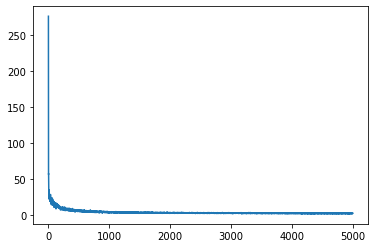

In [16]:
train(mlp)

In [17]:
load_model("mlp.zip",mlp)
def predict(x_rm, graph,model):
    model.x.value = x_rm
    run_steps(graph, monitor=False, train=False)

    return model.y_pre.value

print("预测值：",predict(x_[10],graph_sort,mlp),"真实值：",y_[10])
    #预测值： 18.52534730151933 真实值： 15.0


预测值： 17.6478606386398 真实值： 15.0
